# Figure 3 Inference over three-parameter DSO wiring rule

This notebook contains the Python code for generating Figure 3 in the paper. 
The figure shows the results for performing SBI over the three parameters of the DSO wiring rule, given seven connectivity measurements from thalamus to barrel cortex. 

The training data and inference objects are pre computed and only loaded for visualization in this notebook.
The following results are loaded: 
- SBI object, simulator, prior, posterior for inference given observed data
- posterior predictive checks: simulated data from samples from the posterior. 
- cross validation results: predictive samples from each of seven posteriors, where each posterior estimate was trained on only six of the seven measurements. 

For details on how to perform inference, see `/tutorials` or `/scripts`


In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import numpy as np
import pickle
import sys
import torch

sys.path.append("../")
from plotting_utils import custom_marginal_plot

from sbi.simulators import simulate_in_batches
from sbi.inference import prepare_for_sbi
from sbi.analysis import pairplot, conditional_pairplot
from sbi.inference import SNPE

from consbi import BASE_PATH, DATA_PATH, RESULTS_PATH

plt.style.use(BASE_PATH.joinpath("figures/plotting_settings.mplstyle"))
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load literature inference results
with open(RESULTS_PATH.joinpath("npe_dso_gaussian005_n1000000.p"), "rb") as fh:
    prior, estimator, posterior, thos, xos, kwargs, seed = pickle.load(fh).values()    

    
with open(DATA_PATH.joinpath("presimulated_dso_gaussian005_n1000000.p"), "rb") as fh:
    prior, ths, xs = pickle.load(fh).values()

## Generate predictive samples and data

In [13]:
# set observed data values from literature.
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])
posterior.set_default_x(xo)
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]

In [14]:
# NOTE: set True if predictive simulations should be run again (takes some time).
generate_new_results = False
load_predictive_samples = False
num_samples = 10000
num_workers = 2

if generate_new_results:    
    from consbi.simulators.utils import get_batch_simulator
    from consbi.simulators import RuleSimulator, default_rule
    
    path_to_model = BASE_PATH.as_posix() + "/data/structural_model"
    simulator = RuleSimulator(
        path_to_model,
        default_rule,
        verbose=True,
        num_subsampling_pairs=50,
        prelocate_postall_offset=False,
    )
    batch_simulator = get_batch_simulator(simulator)
    
    thos = posterior.sample((num_samples,), x=xo, show_progress_bars=False)
    batch_simulator, prior = prepare_for_sbi(simulator, prior)
    
    # xs = simulate_in_batches(batch_simulator, ths, num_workers=num_workers, sim_batch_size=50)
    xos = simulate_in_batches(batch_simulator, thos, num_workers=num_workers, sim_batch_size=50)
    
    # save posterior predictive samples
    with open("npe_posterior_predictive.p", "wb") as fh:
        pickle.dump(dict(thos=thos, xos=xos), fh)
elif load_predictive_samples:
    # load samples
    with open("posterior_predictive_samples.p", "rb") as fh: 
        thos, xos = pickle.load(fh).values()
        
    with open(RESULTS_PATH.joinpath("prior_predictive_samples_dso.p"), "rb") as fh: 
        ths, xs = pickle.load(fh).values()
else: 
    # for multi-round results, select last posterior.
    if isinstance(thos, list):
        thos = thos[-1]

In [15]:
# load predictive samples from unparametrized DSO rule (Udvary et al.)
with open(RESULTS_PATH.joinpath("unparametrized_dso_rule_predictive_samples.p"), "rb") as fh:
    thos_initial, xos_initial = pickle.load(fh).values()

# load cross validation results
with open(RESULTS_PATH.joinpath("cross_validation_results_default_rule.p"), "rb") as fh:
    predictive_samples_lit = pickle.load(fh)["predictive_samples_lit"]
    
# collect predicted xos for each dimension, shape 1000 x 7.
predicted_xos_per_dim = torch.stack([xii[:, ii] for ii, xii in enumerate(predictive_samples_lit)]).T.numpy()

## Figure 4 version June 2023
Gaussian prior with scale 0.05, contour marginals

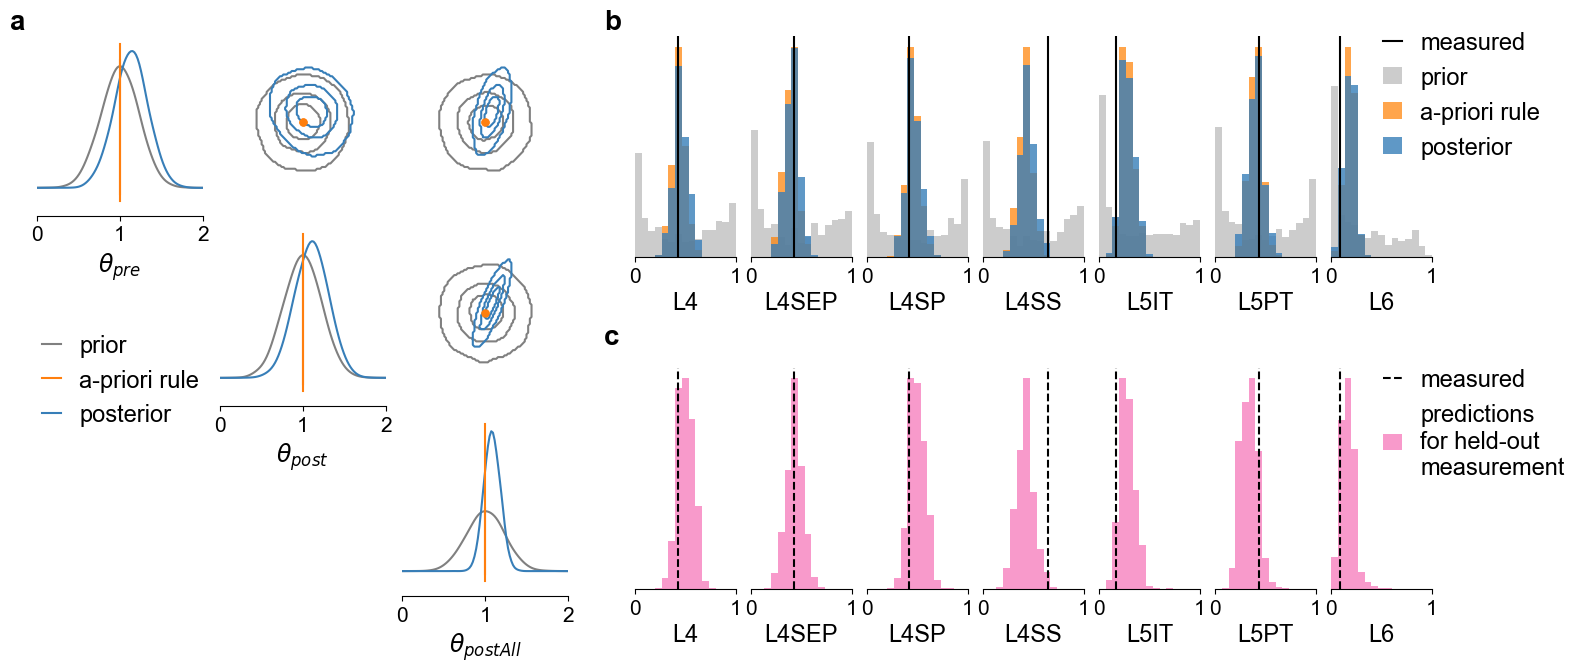

In [16]:
fig = plt.figure(figsize=(18, 7))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.4, .6])
# set KDE values
num_bins = 100
bw_method = 0.3
handlelength = 0.8

# left column
left_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0.1, hspace=0.1,)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# Posteriors
posterior_opts = dict(upper="contour", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.34, 0.68, 0.95]), 
                      points_colors=["C1"],
                      points_offdiag=dict(marker=".", markersize=10), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      hist_diag=dict(bins=10, histtype="step", density=True),
                      labels = param_labels,

           )

fig, ax1 = pairplot([ths[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    points = torch.ones(1, 3),
                    fig=fig, axes=ax1, 
                    limits=[[0, 2]] * 3, 
#                     ticks =[[0, 1]] * 3,
                    **posterior_opts
                   )
fig, ax1 = pairplot([thos[:num_samples]], 
                    samples_colors=[colors[0]],
                    points = torch.ones(1, 3),
                    fig=fig, axes=ax1, 
                    limits=[[0, 2]] * 3, 
#                     ticks =[[0, 1]] * 3,
                    **posterior_opts
                   )

plt.sca(ax1[0, 0])
plt.legend(["prior", "a-priori rule", "posterior"], 
           bbox_to_anchor=(-.1, -.6),
           handlelength=handlelength,
           loc=2)

for idx in range(3):
    plt.sca(ax1[idx, idx])
    plt.xticks([0, 1, 2])


# Posterior predictives
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=.5)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# right_grid = outer_grid[0, 1].subgridspec(2, 7, wspace=0.2, hspace=0.5,)
# ax2 = right_grid.subplots(subplot_kw=dict(sharey=True, sharex=True))


bins = np.linspace(0, 1, 16)
# Predictive distributions
custom_marginal_plot(ax2, xs.squeeze().numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos_initial.squeeze().numpy(),
                     points=None,
                     x_label="a-priori rule", 
                     points_label="measured", 
                     show_xlabels=False,
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[1], 
                     histtype="stepfilled",
                     alpha=0.7,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.squeeze().numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[0], 
                     alpha=0.8,
                     plot_legend=False,)


plt.sca(ax2[-1])
bbox_to_anchor=(0.3, .35)
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# Cross validation
custom_marginal_plot(ax3, predicted_xos_per_dim, xo, 
                     x_label="predictions\nfor held-out\nmeasurement", 
                     points_label="measured", 
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[3], 
                     handlelength=handlelength,
                     bbox_to_anchor=(0.28, .67), 
                     plot_legend=False,
                     points_line_style="--",
                    )

plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=(0.3, .4), 
           loc="lower left",
          );

# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.46

x1 = 0.11
x2 = 0.44
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "c", fontsize=fontsize, fontweight=weight);

## Posterior Analysis

In [17]:
for end in ["png", "pdf", "eps"]:
    fig.savefig(f"figure3_SBI_results_gaussian005_with_apriori_rule.{end}", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
from sbi.utils.metrics import c2st

for ii in range(7):
    print(
        c2st(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1), xos[:1000, ii].reshape(-1, 1))
    )
#     print(np.power(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1) - xos[:1000, ii].reshape(-1, 1), 2).sum())

tensor([0.5285])
tensor([0.5520])
tensor([0.5245])
tensor([0.6120])
tensor([0.5230])
tensor([0.5915])
tensor([0.4920])


In [36]:
xo

array([[0.43, 0.43, 0.42, 0.64, 0.17, 0.44, 0.09]])

In [18]:
xos.mean(0)

tensor([0.4552, 0.4053, 0.4660, 0.4379, 0.2848, 0.4009, 0.1775])

In [39]:
xos.std(0)

tensor([0.0774, 0.0753, 0.0777, 0.0770, 0.0686, 0.0765, 0.0569])

In [37]:
predicted_xos_per_dim.mean(0) - xo.squeeze()

array([ 0.06890003, -0.00125998,  0.0732    , -0.22563998,  0.10932   ,
       -0.10447997,  0.07026001])

In [38]:
xos.mean(0) - xo.squeeze()

tensor([ 0.0252, -0.0247,  0.0460, -0.2021,  0.1148, -0.0391,  0.0875],
       dtype=torch.float64)

In [45]:
print("C2ST between initial and inferred DSO rule predictions.")
num_c2st_samples = 1000
for ii in range(7):
    print(
        c2st(torch.tensor(xos_initial)[:num_c2st_samples, ii].reshape(-1, 1), xos[:num_c2st_samples, ii].reshape(-1, 1))
    )

C2ST between initial and inferred DSO rule predictions.
tensor([0.5160])
tensor([0.5150])
tensor([0.5245])
tensor([0.5330])
tensor([0.5085])
tensor([0.5035])
tensor([0.5075])


## Posterior and conditional posterior correlations

In [23]:
# posterior correlations
np.corrcoef(thos, rowvar=False, )

array([[ 1.        , -0.1412342 ,  0.48073069],
       [-0.1412342 ,  1.        ,  0.79337252],
       [ 0.48073069,  0.79337252,  1.        ]])

In [26]:
from sbi.analysis import conditional_corrcoeff

posterior.set_default_x(xo)
conditions = posterior.sample((1000,))

cond_corr = conditional_corrcoeff(posterior, 
                                  limits=torch.tensor([[-1.0, 3.0]] * 3), 
                                  condition=conditions)
cond_corr

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[ 1.0000, -0.9791,  0.9829],
        [-0.9791,  1.0000,  0.9920],
        [ 0.9829,  0.9920,  1.0000]])

In [27]:
posterior.map() - thos.std(0) * 2, posterior.map() + thos.std(0) * 2

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

(tensor([0.7381, 0.6898, 0.8835]), tensor([1.5471, 1.5052, 1.2736]))

In [28]:
thos.mean(0)

tensor([1.1358, 1.1033, 1.0807])

In [17]:
thos.std(0)

tensor([0.2022, 0.2038, 0.0975])

In [29]:
posterior.map()

tensor([1.1426, 1.0975, 1.0785])